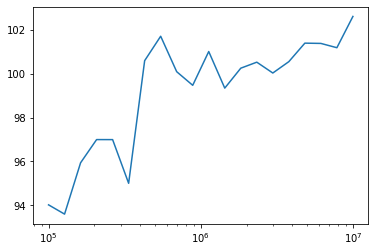

In [19]:
import copy
import itertools

from constants import *
from helperTools import *
from HalbachLensClass import SegmentedBenderHalbach
from elementPT import HalbachBenderSimSegmented



results=np.array([[1.00000000e+05, 9.40211358e+01],
                  [1.27427499e+05, 9.35983319e+01],
                  [1.62377674e+05, 9.59374342e+01],
                  [2.06913808e+05, 9.69957719e+01],
                  [2.63665090e+05, 9.69942000e+01],
                  [3.35981829e+05, 9.50030699e+01],
                  [4.28133240e+05, 1.00592797e+02],
                  [5.45559478e+05, 1.01707013e+02],
                  [6.95192796e+05, 1.00090269e+02],
                  [8.85866790e+05, 9.94700060e+01],
                  [1.12883789e+06, 1.01009674e+02],
                  [1.43844989e+06, 9.93419337e+01],
                  [1.83298071e+06, 1.00250374e+02],
                  [2.33572147e+06, 1.00524374e+02],
                  [2.97635144e+06, 1.00030384e+02],
                  [3.79269019e+06, 1.00547887e+02],
                  [4.83293024e+06, 1.01391538e+02],
                  [6.15848211e+06, 1.01379519e+02],
                  [7.84759970e+06, 1.01183449e+02],
                  [1.00000000e+07, 1.02608939e+02]])
plt.semilogx(results[:,0],results[:,1])


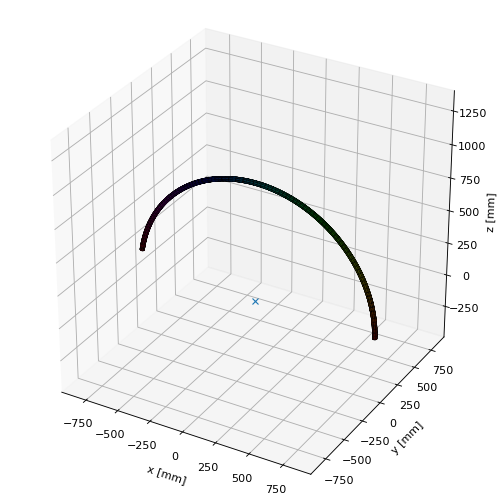

In [3]:
%matplotlib inline
Lm=.025
ucAngle=.6*Lm/1.0
rb=.9
rp=.01
bender=SegmentedBenderHalbach(rp,rb,ucAngle,Lm,numLenses=100,positiveAngleMagnetsOnly=True)
bender.display()

In [4]:
thetaArr=np.linspace(bender.lensAngleArr.min()-2*ucAngle,bender.lensAngleArr.max()+2*ucAngle,20)
rArr=np.linspace(rb-rp/2,rb+rp/2,10)
yArr=np.linspace(-rp/2,rp/2,10)
coordsPolar=np.array(list(itertools.product(thetaArr,rArr,yArr)))
xArr,zArr=np.cos(coordsPolar[:,0])*coordsPolar[:,1],np.sin(coordsPolar[:,0])*coordsPolar[:,1]
yArr=coordsPolar[:,2]
coords=np.column_stack((xArr,yArr,zArr))


In [12]:
t=time.time()
BVecBender=bender.B_Vec(coords)
print(time.time()-t)

0.385775089263916


In [5]:
def get_Valid_SubCoord_Indices(thetaArr,lensSplitIndex1,lensSplitIndex2,thetaLower,thetaUpper):
    if lensSplitIndex2==len(lensAngles) and lensSplitIndex1==0:#use all coords indices because all lenses are used
        validCoordIndices=np.ones(len(thetaArr)).astype(bool)
    elif lensSplitIndex1==0:
        validCoordIndices= thetaArr<=thetaUpper
    elif lensSplitIndex2==len(lensAngles):
        validCoordIndices=thetaArr>thetaLower
    else:
        validCoordIndices=(thetaArr<=thetaUpper) & (thetaArr>thetaLower)
    return validCoordIndices

In [6]:
def get_Seperated_Split_Indices(thetaArr: np.ndarray,deltaTheta: float,thetaMin: float,thetaMax: float)-> tuple[int,int]:
    """Return indices that split thetaArr such that the beginning and ending stretch past by -deltaTheta and deltaTheta
    respectively. If thetaMin (thetaMax) is <=thetaArr.min() (>=thetaArr.max()) then don't check that the seperation is
    satisfied at the beginning (ending). The ending index is one index past the desired index per slicing rules"""
    assert thetaMax>thetaMin and len(thetaArr.shape)==1
    assert np.all(thetaArr==thetaArr[np.argsort(thetaArr)]) #must be ascending order
    indexStart=0 if thetaMin-deltaTheta<thetaArr.min() else np.argmax(thetaArr>thetaMin-deltaTheta)-1
    #remember, indexEnd is one past the last index!
    indexEnd=len(thetaArr) if thetaMax+deltaTheta>thetaArr.max() else np.argmax(thetaArr>thetaMax+deltaTheta)
    if not indexStart==0:
        assert thetaArr[indexStart]<=thetaMin-deltaTheta
    if not indexEnd==len(thetaArr):
        assert thetaArr[indexEnd]>=thetaMax+deltaTheta
    return indexStart,indexEnd

In [7]:
from HalbachLensClass import billyHalbachCollectionWrapper
lensAngles=bender.lensAngleArr
angleSymCutoff=1.5*np.pi
assert lensAngles.max()<angleSymCutoff # Any angle above this is assumed to be negative, so the bender shouldn't be this long
lenses=bender.lensList
numLensBorder=2 #number of lenses boarding region for field computationg
lensBorderSep=2*ucAngle*numLensBorder+1e-6
# coordAngles=np.linspace(layerAngles[0],layerAngles[-1],1000)
splitFactor=5 #roughly number of lenses (minus number of lenses bordering) per split
numSplits=round(len(lenses)/(2*numLensBorder+splitFactor))
numSplits=1 if numSplits==0 else numSplits
angleSplits=np.linspace(lensAngles.min(),lensAngles.max(),numSplits+1)
BVec=np.zeros(coords.shape)
thetaArr=np.arctan2(coords[:,2],coords[:,0])
thetaArr[thetaArr<angleSymCutoff-2*np.pi]+=2*np.pi #if an angle is larger than 3.14, arctan2 doesn't know this,
#and confines angles between -pi to pi. So I make an assumption here that lets me change the angle
indicesComputed=np.zeros(len(thetaArr)) #to track which indices fields are computed for. Only for an assert check
for i in range(len(angleSplits)-1):
    thetaLower,thetaUpper=angleSplits[i],angleSplits[i+1]
    lensSplitIndex1,lensSplitIndex2=get_Seperated_Split_Indices(lensAngles,lensBorderSep,thetaLower,thetaUpper)
    subLenses=lenses[lensSplitIndex1:lensSplitIndex2]
    collection=billyHalbachCollectionWrapper(subLenses)
    validCoordIndices=get_Valid_SubCoord_Indices(thetaArr,lensSplitIndex1,lensSplitIndex2,thetaLower,thetaUpper)
    if sum(validCoordIndices)>0:
        indicesComputed+=validCoordIndices
        BVec[validCoordIndices]+=collection.B_Vec(coords[validCoordIndices])
assert np.all(indicesComputed==1) #check that every coord index was used once and only once
1e2*np.mean(np.abs(BVec-BVecBender),axis=0)/np.mean(np.abs(BVec),axis=0)

array([2.75025713e-06, 1.45723822e-06, 3.32510747e-06])

In [12]:
BVec=bender.B_Vec(coords,useApprox=True)
1e2*np.mean(np.abs(BVec-BVecBender),axis=0)/np.mean(np.abs(BVec),axis=0)
np.max((BVec-BVecBender)/BVec)

0.0007500216299017669

In [15]:
t=time.time()
BVec_Exact=bender.BNorm_Gradient(coords)
print(time.time()-t)

here
here
here
here
here
here
8.965485095977783


In [16]:
t=time.time()
BVec_Approx=bender.BNorm_Gradient(coords,useApprox=True)
print(time.time()-t)

here
here
here
here
here
here
1.8367722034454346


In [17]:
np.max(1e2*(BVec_Exact-BVec_Approx)/BVec_Exact)

0.0020720142159917233

In [2]:
coordsCenter,coordsCartesian=elDeviation.make_Deviation_Data_Coords()

In [3]:
from HalbachLensClass import SegmentedBenderHalbach

In [4]:
np.random.seed(42) #todo: get rid of this
lensIdeal=SegmentedBenderHalbach(elPerfect.rp, elPerfect.rb, elPerfect.ucAng, elPerfect.Lm,
                                               numLenses=numMagnets, applyMethodOfMoments=True,positiveAngleMagnetsOnly=True,useMagnetError=False)
np.random.seed(42) #todo: get rid of this
lensDeviated=SegmentedBenderHalbach(elDeviation.rp, elDeviation.rb, elDeviation.ucAng, elDeviation.Lm,
                                          numLenses=numMagnets, applyMethodOfMoments=True,positiveAngleMagnetsOnly=True,useMagnetError=True)

In [5]:
def field_Perturbation(qEl):
    [Bgradx,Bgrady,Bgradz],B0=lensIdeal.BNorm_Gradient(qEl,returnNorm=True)
    valsIdeal=np.array([Bgradx,Bgrady,Bgradz,B0])
    [Bgradx,Bgrady,Bgradz],B0=lensDeviated.BNorm_Gradient(qEl,returnNorm=True)
    valsDeviated=np.array([Bgradx,Bgrady,Bgradz,B0])
    vals=valsDeviated-valsIdeal
    Fx,Fy,Fz=-vals[:3]*SIMULATION_MAGNETON
    Fy,Fz=Fz,-Fy
    V=vals[-1]*SIMULATION_MAGNETON
    return Fx,Fy,Fz,V
index=261
x,y,z=coordsCartesian[index]
print(coordsCartesian[index])
print(coordsCenter[index])
# x,y,z=x,z,-y
# print(x,y,z)
qEl=np.asarray([x,y,z])

# field_Perturbation(qEl)

[ 0.95773858 -0.0086815   0.28778844]
[ 0.33460422  0.         -0.0086815 ]


In [6]:
index=261
x,y,z=coordsCartesian[index]
print(coordsCartesian[index],coordsCenter[index])
# y+=1e-5
qHalbach=np.asarray([x,y,z])
x,y,z=x,z,-y
qEl=np.asarray([x,y,z])
# print(coordsCenter[index])
print(elDeviation.force(qEl)-elPerfect.force(qEl))
print(field_Perturbation(qHalbach)[:-1])
# print(field_Perturbation(qHalbach)[:-1]+elPerfect.force(qEl))

[ 0.95773858 -0.0086815   0.28778844] [ 0.33460422  0.         -0.0086815 ]
cartesian 0.9577385772902806 -0.008681500302071005 0.28778844204739795
center 0.33460421758588127 -3.469446951953614e-18 -0.008681500302071005
[60.23143933 20.58276043 15.62553715]
(60.23143932760299, 20.582760434351012, 15.62553715046676)


In [3]:
import numpy as np
np.tan(.1),np.sin(.1)

(0.10033467208545054, 0.09983341664682815)

In [21]:
data=np.array([0.59358765, 0.73831024, 0.71412211, 0.76487371, 0.77081482,
               0.66915509, 0.73629484, 0.71798777, 0.82648226, 0.78208901,
               0.74013826, 0.7573325 , 0.76545081, 0.81434752, 0.72557242,
               0.73725031, 0.80170659, 0.76648397, 0.71676238, 0.76989566,
               0.73966908, 0.81051598, 0.72064941, 0.70312636, 0.77790341,
               0.73567753, 0.71063524, 0.78621325, 0.78050114, 0.73822535])
data=data[1:]
np.mean(data),np.std(data)

(0.752351276551724, 0.03620937794199646)

In [22]:
'a'+4

TypeError: can only concatenate str (not "int") to str

In [48]:
i=0
for coords in coordsCartesian:
    x,y,z=coords
    x,y,z=x,z,-y
    qEl=np.asarray([x,y,z])
    if np.any(np.isnan(elPerfect.force(qEl))):
        i+=1
i/len(coordsCartesian)

0.5692307692307692

In [2]:
# import copy
HalbachBenderSimSegmentedMutant=copy.deepcopy(HalbachBenderSimSegmented)
def fake_Field_Force(x,y,z):
    K=100.0
    Fx,Fy,Fz,V=K*x,5*K*y,-K*z,K**2*(x+y+z)
    return Fx,Fy,Fz,V

coordsCenter,coordsCartesian=elPerfect.make_Deviation_Data_Coords()
fieldVals=np.asarray([fake_Field_Force(*coord) for coord in coordsCartesian])
dataUnshaped=np.column_stack((coordsCenter,fieldVals))
data=elPerfect.shape_Field_Data_3D(dataUnshaped)
HalbachBenderSimSegmentedMutant.generate_Deviation_Data=lambda *args: data
elDeviation=HalbachBenderSimSegmentedMutant(PTL_Dummy(),Lm,rp,numMagnets,rb,1e-3,1.0,True)

centerFrame 0.04369900066666587 0.0010004995003747297 0.001


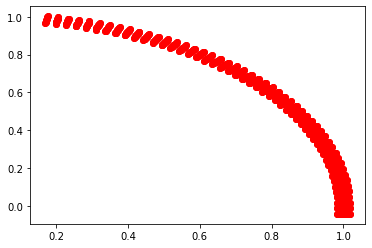

In [3]:
for coord in coordsCartesian[:5000]:
    x,y,z=coord
    x,y,z=x,z,-y
    if z>.01:
        plt.scatter(x,y,c='r')
plt.show()


In [7]:
from constants import SIMULATION_MAGNETON
# r=rb+rp/2.0
# x,y,=r*np.cos(elPerfect.ang*.5),r*np.sin(elPerfect.ang*.5)
# z=-rp/3.0
index=1751
x,y,z=coordsCartesian[index]
print(coordsCenter[index])
x,y,z=x,z,-y
qEl=np.asarray([x,y,z])
print(elPerfect.force(qEl),elDeviation.force(qEl))
print(-np.array(fake_Field_Force(*qEl)[:3])*SIMULATION_MAGNETON+elPerfect.force(qEl))


[ 0.4995744   0.00197169 -0.01380184]
centerFrame 0.4998019432044824 0.0026410079084515647 -0.014301840291481734
[-9832.39909096 -1543.53057734 43083.49895634] [-81451.27480675  33681.81618491  48775.83638058]
[ -81451.51125973 -177670.86010676   41945.0314715 ]


In [19]:
targetAngle=np.pi
magnetWidth = ap * np.tan(2 * np.pi / 24) * 2
Lcap=.2
yokeWidth=magnetWidth
ucAngle=np.arctan(Lseg/(2*(rb-ap-yokeWidth)))
numMagnets=50
ang=ucAngle*2*numMagnets

In [44]:
from scipy.spatial.transform import Rotation as Rot
def orbit_To_Cartesian(s,xo,yo):
    if 0.0<=s<Lcap:
        x,y,z=rb+xo,yo,s-Lcap
    elif Lcap<=s<Lcap+ang*rb:
        theta=(s-Lcap)/rb
        r=rb+xo
        x,y,z=np.cos(theta)*r,yo,np.sin(theta)*r
    elif Lcap+ang*rb<=s:#<=ang*rb+2*Lcap:
        theta=ang
        r=rb+xo
        x0,z0=np.cos(theta)*r,np.sin(theta)*r
        deltaS=s-(ang*rb+Lcap)
        thetaEndPerp=np.pi+np.arctan(-1/np.tan(theta))
        phi=thetaEndPerp
        x=x0+np.cos(phi)*deltaS
        z=z0+np.sin(phi)*deltaS
        y=yo
    else:
        raise ValueError
    return x,y,z

def cartesian_To_Orbit(x,y,z):
    # convert from cartesian in lens frame, to orbit in lens frame
    if x > 0.0 and -Lcap <= z <= 0.0:
        s = Lcap + z
        xc = x - rb
        yc = y
    else:
        theta = full_Arctan(z, x)
        if theta <= ang:
            s = theta * rb + Lcap
            xc = np.sqrt(x ** 2 + z ** 2) - rb
            yc = y
        elif ang < theta <= 2 * np.pi:  # i'm being lazy here and not limiting the real end
            x0, z0 = np.cos(ang) * rb, np.sin(ang) * rb
            thetaEndPerp = np.pi - np.arctan(-1 / np.tan(ang))
            x, z = x - x0, z - z0
            deltaS, xc = np.cos(thetaEndPerp) * x + np.sin(-thetaEndPerp) * z, np.sin(thetaEndPerp) * x + np.cos(
                thetaEndPerp) * z
            yc = y
            xc = -xc
            s = (ang * rb + Lcap) + deltaS
        else:
            raise ValueError
    return s, xc, yc
s=ang*rb+5*Lcap
xo=2e-3
yo=1e-3
print(s,xo,yo)
x,y,z=orbit_To_Cartesian(s,xo,yo)
# print(x,y,z)
cartesian_To_Orbit(x,y,z)

2.361748555323893 0.002 0.001


(2.361748555323893, 0.002000000000000085, 0.001)

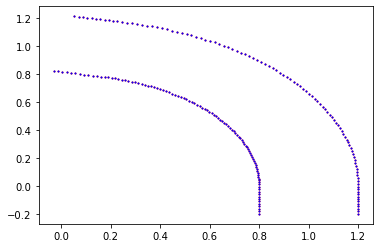

(200, 3)


In [45]:
Ls=2*Lcap+ang*rb
numS=100
numR=2
soArr=np.linspace(0.0,Ls,numS)
xoArr=np.linspace(-ap*10,ap*10,numR)
yoArr=[0]#xoArr.copy()
coordsOrbit=arr_Product(soArr,xoArr,yoArr)
coords=np.asarray([orbit_To_Cartesian(*coordOrbit) for coordOrbit in coordsOrbit])
for coord in coords:
    x,y,z=coord
    plt.scatter(x,z,c='r',s=1)
    s,xc,yc=cartesian_To_Orbit(x,y,z)
    x,y,z=orbit_To_Cartesian(s,xc,yc)
    plt.scatter(x,z,c='b',s=1)

plt.show()
print(coords.shape)

In [ ]:
el=

In [60]:
t=time.time()
bender = SegmentedBenderHalbach(ap, rb, ucAngle, Lm, numMagnets, positiveAngleMagnetsOnly=True,applyMethodOfMoments=False)
vals=bender.BNorm_Gradient(coords,returnNorm=True)
print(time.time()-t)

1.7381608486175537


In [13]:
stuff=[int,int,int]
tuple[10*(float,)]

tuple[float, float, float, float, float, float, float, float, float, float]

In [5]:
lens=PTL.elList[1]
L,rp=lens.L,lens.rp
shifty=500e-6
shiftz=500e-6
qTest1=np.asarray([L/2.0,rp/2.0,rp/2.0])
qTest2=qTest1.copy()
qTest1[1]-=shifty
qTest1[2]-=shiftz

print(lens.force(qTest1))
lens.perturb_Element(500e-6,shiftz,0.0,0.0)
print(lens.force(qTest2))
lens.perturb_Element(0.0,0.0,0.0,0.0)

[ 7.27702286e-08 -1.15600754e+04 -1.15085503e+04]
[ 7.27702286e-08 -1.15600754e+04 -1.15085503e+04]


In [ ]:
plt.plot(pointsList,results)
plt.show()
results

NameError: name 'mSymFunc' is not defined

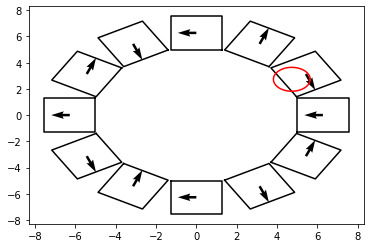

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.affinity import rotate
from HalbachLensClass import Layer

rp=(.05,)
width=.0254

thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # location of 12 magnets
thetaArr=thetaArr.reshape(-1,len(rp)).T
phiArr = np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization
phiArr=phiArr.reshape(-1,len(rp)).T
quiverData=[]
for r,r_phi,r_theta in zip(rp,phiArr,thetaArr):
    for phi,theta in zip(r_phi,r_theta):
        x,y=(r+width/2)*np.cos(theta)*1e2,(r+width/2)*np.sin(theta)*1e2
        quiverData.append([x,y,np.cos(phi),np.sin(phi)])
quiverData=np.asarray(quiverData)

squareCoords=np.asarray([(rp[0],-width/2),(rp[0]+width,-width/2),(rp[0]+width,width/2),(rp[0],width/2)])*1e2
squareOriginal=Polygon(squareCoords)
angleArr=np.linspace(0,np.pi*2,13)[:-1]
for angle in angleArr[:]:
    square=rotate(squareOriginal,angle,origin=(0,0),use_radians=True)
    plt.plot(*square.exterior.xy,c='black')





plt.quiver(*quiverData.T,label='Magnets')
rShim=.0546
phi0=np.pi/6
radius=.911
psi0=5.89
point0=Point([1e2*rShim,0])
phiArr=phi0+np.linspace(0.0,2*np.pi,7)[1:]
phiArr=np.flip(phiArr)

assert abs(abs(phiArr[1]-phiArr[0])-np.pi/3)<1e-6
psi=psi0
m=np.asarray([np.cos(psi),np.sin(psi)])
quiverData=[]
i=0
booList=[False,True]*5
for phi in phiArr[:3]:
    point=rotate(point0,phi,origin=(0.0,0.0),use_radians=True)
    plt.plot(*point.buffer(radius).exterior.xy,c='r')
    x,y=1e2*rShim*np.cos(phi),1e2*rShim*np.sin(phi)
    mSym=mSymFunc(m,factors=i,flipDipolexy=booList[i])
    quiverData.append([x,y,*mSym])
    i+=1
quiverData=np.asarray(quiverData)
plt.quiver(*quiverData.T,color='r',label='shims')# plt.quiver(quiverData[:,0],quiverData[:,1],quiverData[:,2],quiverData[:,3],color='r',label='shims')

layer=Layer(0.0,width,.5,rp)
xArr=np.linspace(-rp[0],rp[0],50)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
BVec=layer.B(coords)
B=np.linalg.norm(BVec,axis=1)
B[np.linalg.norm(coords,axis=1)>rp[0]*.99]=np.nan
B=B.reshape(len(xArr),len(xArr))
plt.imshow(B,extent=[min(xArr)*100.0,max(xArr)*100.0]*2)
# BxGrid=BVec[:,0].reshape(len(xArr),len(xArr))
# ByGrid=BVec[:,1].reshape(len(xArr),len(xArr))
# plt.streamplot(xArr*1e2,xArr*1e2,BxGrid,ByGrid,density=.8)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend()
plt.xlabel('cm')
plt.ylabel('cm')
plt.title('Run1 magnetization direction of \n lens magnets and shims')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [ ]:
booList

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phi0=0*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
phiArr=np.arange(0, 6) * 4 * np.pi / 3
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    if rotations%2==1:
        mu = np.tan(rotations*rotationAngle/2)
        M_uc = np.asarray([[1 - mu ** 2, 2 * mu], [2 * mu, mu ** 2 - 1]]) * 1 / (1 + mu ** 2)  # reflection matrix
        mSym=M_uc@m
    else:
        M_Angle=rotationAngle*rotations
        MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
        mSym=MRot@m
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
phi0=.5*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    M_Angle=rotationAngle*rotations
    MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
    mSym=MRot@m
    mSym*=(-1)**rotations
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



In [3]:
from asyncDE import solve_Async
from helperTools import *
def func(X):
    return np.sin(X[0])
solve_Async(func,[(0,1.0)],10,saveData='dummy',timeOut_Seconds=100)

------ITERATIONS:  10
POPULATION VARIABILITY: [0.2795085]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.02190996])
cost: 0.0219082086845373
------ITERATIONS:  20
POPULATION VARIABILITY: [0.28688691]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
------ITERATIONS:  30
POPULATION VARIABILITY: [0.155358]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
------ITERATIONS:  40
POPULATION VARIABILITY: [0.06905436]
BEST MEMBER BELOW
---population member---- 
DNA: array([0.])
cost: 0.0
finished with total evals:  46


In [ ]:
import numpy as np

a=np.array([0.22335083, 0.05468504, 0.01778291, 1.86398975, 5.89642321])
b=np.array([0.22336635, 0.05398954, 0.01994955, 2.174386  , 5.1246072 ])
c=np.array([0.22336904, 0.05486956, 0.01967456, 1.16595304, 4.66104557])
d=np.array([0.22232782 ,0.05411236 ,0.01467107 ,1.69968186 ,5.40909307])
e=np.array([0.2228413  ,0.05462561 ,0.01132046 ,1.28740702 ,5.31414559])
arr=np.column_stack((a,b,c,d,e))
np.std(arr,axis=1),np.mean(arr,axis=1)

In [ ]:
#locked phi,locked theta, variable radius
a=np.array([0.2425    , 0.06891085, 0.02262274, 3.05662444, 0.02194268,
            0.06575895, 0.04839916, 5.17701814, 0.0254,.08078    ])
e=np.zeros(len(a))*np.nan
e[0]=.23
e[-1]=1.0

rowLabels=['L', 'r', 'deltaZ','psi','radius','r', 'deltaZ','psi','radius','cost']
colLabels=['param,SI','run1','baseline lens']
cellText=[]




cellText=[rowLabels,arrToStr(a),arrToStr(e)]
cellText=list(zip(*cellText))
fig, ax = plt.subplots()
ax.set_axis_off()
ax.table(cellText=cellText,cellLoc ='center',loc ='upper left',colLabels=colLabels)
plt.savefig('poop',dpi=100)
plt.show()

In [ ]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254

DNAList=[]
phaseList=[0.0,0*np.pi/24]
print(phaseList)
for phase in phaseList:
    dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
    DNAList.append(dict)
lens=GeneticLens(DNAList)
xArr=np.linspace(-rp*.9,rp*.9,100)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
image=vals.reshape(len(xArr),len(xArr))
plt.imshow(image)
plt.show()

In [ ]:
from geneticLensClass import GeneticLens
import numpy as np
import matplotlib.pyplot as plt

rp=.05
width=.0254
length=.0254*10
def plot_Field(phaseList):
    DNAList=[]
    for phase in phaseList:
        dict={'component':'layer','length':length,'width':width,'rp':rp,'phase':phase}
        DNAList.append(dict)
    lens=GeneticLens(DNAList)
    xArr=np.linspace(-rp*.9,rp*.9,100)
    coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
    vals=np.linalg.norm(lens.BNorm_Gradient(coords),axis=1)
    vals[np.linalg.norm(coords[:,:2],axis=1)>xArr.max()]=np.nan
    image=vals.reshape(len(xArr),len(xArr))
    print(np.nansum(image))
    plt.imshow(image)
    plt.show()
plot_Field([0.0]*2)
plot_Field([np.pi/12]*2)
plot_Field([0.0,np.pi/6])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data=np.loadtxt("data")

In [ ]:
data

In [ ]:
plt.scatter(data[:,0],data[:,3])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from HalbachLensClass import Layer,SegmentedBenderHalbach
import numpy as np
from parallel_Gradient_Descent import gradient_Descent
from scipy.optimize import curve_fit
import multiprocess as mp
import time
rp0,rb0,Lm0,extraSpace0=.01,1.0,.0254/2.0,0.0
magnetWidth = rp0 * np.tan(2 * np.pi / 24) * 2
yokeWidth=magnetWidth
Lseg = Lm0 + extraSpace0 * 2
ucAng=np.arctan(Lseg/(2*(rb0-rp0-yokeWidth)))

In [ ]:

# numPointsGridEdge=500
# xArr=np.linspace(-rp0,rp0,numPointsGridEdge)
# coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
# def makge_And_Trim_Vals(lens,rp):
#     vals=np.asarray([np.linalg.norm(lens.B(np.asarray([coord]))) for coord in coords])
#     vals[np.linalg.norm(coords,axis=1)>=rp]=np.nan
#     vals[np.linalg.norm(coords,axis=1)<=.1*rp]=np.nan
#     return vals
# def nominal_Values(rp):
#     lens=Layer(0.0,.025,1.0,.05)
#     return makge_And_Trim_Vals(lens,rp)
# def error_Values(rp,amp=1.0):
#     np.random.seed(int(time.time()*1e6)%10_000)
#     rpMagnetShift=amp*.01*rp*(np.random.random_sample(12)-.5)
#     M_ShiftRelative=amp*.01*(np.random.random_sample(12)-.5)
#     thetaShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     phiShift=amp*(2*np.pi*1/360)*(np.random.random_sample(12)-.5)
#     lens=Layer(0.0,.025,1.0,.05,rMagnetShift=rpMagnetShift,M_ShiftRelative=M_ShiftRelative,thetaShift=thetaShift,phiShift=phiShift)
#     return makge_And_Trim_Vals(lens,rp)
# valsNominal=nominal_Values(rp0)
# imageNominal=valsNominal.reshape((int(np.sqrt(len(valsNominal))),)*2)
# plt.imshow(imageNominal)
# plt.show()

In [ ]:
import multiprocess as mp
numRuns=100
with mp.Pool(8) as pool:
    errorResults=np.asarray(pool.map(error_Values,[rp0]*numRuns))
valsErrorRMS=np.std(errorResults,axis=0)
valsRelativeError=(valsErrorRMS/valsNominal)
imageRelativeError=valsRelativeError.reshape((int(np.sqrt(len(valsNominal))),)*2)
plt.imshow(imageRelativeError)
plt.show()

In [ ]:
coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
valsNanTrimmed=valsRelativeError[~np.isnan(valsRelativeError)]
thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
thetaArr[thetaArr<0.0]+=2*np.pi
#
numBins=100
thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
errorThetaVals=errorThetaVals/thetaFrequency

binCenter=bins[:-1]+(bins[1]-bins[0])/2

plt.plot(binCenter,errorThetaVals)
plt.ylabel('mean relative RMS deviation')
plt.xlabel('theta (radians)')
plt.show()

In [ ]:
# plt.semilogy(thetaArr,valsRelativeError,linewidth=0.0,marker='o',alpha=.1)
# plt.show()

for i in range(len(errorResults)):
    coordsNanTrimmed=coords[~np.isnan(valsRelativeError)]
    valsNanTrimmed=errorResults[i][~np.isnan(valsRelativeError)]-valsNominal[~np.isnan(valsRelativeError)]
    thetaArr=np.arctan2(coordsNanTrimmed[:,1],coordsNanTrimmed[:,0])
    thetaArr[thetaArr<0.0]+=2*np.pi
    #
    numBins=100
    thetaFrequency,bins=np.histogram(thetaArr,bins=numBins)
    errorThetaVals,bins=np.histogram(thetaArr,bins=numBins,weights=valsNanTrimmed)
    errorThetaVals=errorThetaVals/thetaFrequency

    binCenter=bins[:-1]+(bins[1]-bins[0])/2

    # plt.plot(binCenter,errorThetaVals)
    # plt.show()

In [ ]:
# plot radial dependence
rArr=np.sqrt(coords[:,0]**2+coords[:,1]**2)
plt.scatter(rArr,valsRelativeError,alpha=.01)
plt.show()

In [ ]:
#where is the field the smallest in a bender, ie where is the center?

numLens=41
bender=SegmentedBenderHalbach(rp0,rb0,ucAng,Lm0,numLenses=numLens,positiveAngleMagnetsOnly=False)
thetaMaxGeom=np.arctan(Lm0*(numLens/2)/rb0)
thetaMax=Lm0/rb0
assert thetaMax<thetaMaxGeom/5.0 # assert small segment of total bend

In [ ]:

def field_Val(deltaR,theta):
    if isinstance(deltaR,(tuple,list,np.ndarray)):
        deltaR=deltaR[0]
    r=rb0+deltaR
    x,y,z=np.cos(theta)*r,0.0,np.sin(theta)*r
    val=bender.BNorm(np.array([x,y,z]))
    return val
def find_rZero(theta):
    minFunc=lambda x: field_Val(x,theta)
    deltaR_Zero=gradient_Descent(minFunc,[0.0],30e-6,50,parallel=False,disp=False,gradStepSize=1e-6)[0][0]
    rZero=rb0+deltaR_Zero
    return rZero
numPoints=50
thetaArr=np.linspace(-1.0,1.0,numPoints)*thetaMax
with mp.Pool() as pool:
    rZeroArr=np.asarray(pool.map(find_rZero,thetaArr))
xZeroArr=np.array([r*np.cos(theta) for r,theta in zip(rZeroArr,thetaArr)])
zZeroArr=np.array([r*np.sin(theta) for r,theta in zip(rZeroArr,thetaArr)])

In [ ]:
deltaRArr=(rZeroArr-rb0)/1e-6

plt.plot(thetaArr,deltaRArr)
plt.scatter(thetaArr,deltaRArr)
thetaLm=np.arctan(Lm0/rb0)
plt.axvline(x=thetaLm/2.0,c='r')
plt.axvline(x=-thetaLm/2.0,c='r')
# plt.gca().set_aspect('equal')
plt.show()

In [ ]:
#fit sines to the rZero depndence as a function of thea
y=deltaRArr.copy()
# y-=(y.max()+y.min())/2.0
# y/=y.max()
# y-=np.mean(y)
# y/=np.max(y)
a0=np.trapz(y*np.cos(0thetaArr),x=thetaArr)
plt.plot(thetaArr,y)
plt.show()
a0

In [ ]:
numPoints=100
xArr=np.linspace(rb0-(1-np.cos(thetaMax))*rb0-rp0,rp0+rb0,numPoints)
zArr=np.linspace(-1.0,1.0,numPoints)*thetaMax*rb0
coords=np.array(np.meshgrid(xArr,0.0,zArr)).T.reshape(-1,3)
vals=bender.BNorm(coords)
image=np.flip(vals.reshape(numPoints,numPoints),axis=0)
xImage=np.flip(coords[:,0].reshape(numPoints,numPoints),axis=0)
for rowX,rowVal in zip(xImage,image):
    rowX[np.nanargmin(rowVal)]=np.nan
    # print(np.min(rowVal))
plt.imshow(xImage,extent=[xArr.min(),xArr.max(),zArr.min(),zArr.max()])
plt.plot(xZeroArr,zZeroArr,c='r')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import time
from constants import MAGNETIC_PERMEABILITY
import numpy as np
from numpy.linalg import norm
from HalbachLensClass import magpy_Prism,solve_And_Update_Magnetization_Interactions,HalbachLens
from demag_functions import apply_demag
# %matplotlib inline


In [ ]:
from magpylib import Collection
lens=HalbachLens(.15,.0254,.05,applyMethodOfMoments=False,subdivide=False)
BoxList=[p._magnet._magnet for p in lens.layerList[0].RectangularPrismsList]
col=Collection(*BoxList)
apply_demag(col,np.ones(len(BoxList))*.05)
for layer in lens.layerList:
    for prism in layer.RectangularPrismsList:
        #print(1.0-np.linalg.norm(prism._magnet.get_M_Vector()) /np.linalg.norm(prism.M) )
        print(prism._magnet.get_M_Vector()[1])

In [ ]:
lens=HalbachLens(.15,.0254,.05,applyMethodOfMoments=True,subdivide=False)
BoxList=[p._magnet._magnet for p in lens.layerList[0].RectangularPrismsList]
for layer in lens.layerList:
    for prism in layer.RectangularPrismsList:
        #print(1.0-np.linalg.norm(prism._magnet.get_M_Vector()) /np.linalg.norm(prism.M) )
        print(prism._magnet.get_M_Vector()[1])

In [ ]:
0.025999907856928517-.022682154944148047,0.02446192789984869-0.02093190261679334

In [ ]:
import magpylib as magpy
from scipy.spatial.transform import Rotation
import numpy as np
R=Rotation.from_rotvec([0.0,0.0,3.14])


M=1.0
w=1.0
L=2.0
r0=5.0
x0,y0,z0=0.0,0.0,0.0
phase=np.pi/2
psi=.5
thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)+phase  # location of 12 magnets.
phiArr =phase+ np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization


c1 = magpy.Collection()
for theta,phi in zip(thetaArr,phiArr):
    x,y=r0*np.cos(theta),r0*np.sin(theta)
    R=Rotation.from_rotvec([0.0,0.0,phi])
    box=magpy.magnet.Box(magnetization=(M,0.0,0.0),dimension=(w,w,L),position=(x,y,0.0),orientation=R)
    box.move([x0,y0,z0])
    c1.add(box)
    # c.display()
c2 = magpy.Collection()
for theta,phi in zip(thetaArr,phiArr):
    x,y=r0*np.cos(theta),r0*np.sin(theta)
    R=Rotation.from_rotvec([0.0,0.0,phi])
    box=magpy.magnet.Box(magnetization=(M,0.0,0.0),dimension=(w,w,L),position=(x,y,5.0),orientation=R)
    box.move([x0,y0,z0])
    c2.add(box)
    # c.display()
c3 = magpy.Collection(c1,c2)
R=Rotation.from_rotvec([0.0,psi,0.0])
c3.rotate(R,anchor=0.0)
c3.display()

In [ ]:
class Layer:
    def __init__(self,magnetWidths,magnetLength):
        pass

In [ ]:
from scipy.spatial.transform import Rotation
halfAngMax=1*np.pi/180
x1Rand=halfAngMax*(2*(np.random.random_sample()-.5))
x2Rand=halfAngMax*(2*(np.random.random_sample()-.5))
X=[1.0,0.0,0.0]
r1=Rotation.from_rotvec([0,x1Rand,0])
r2=Rotation.from_rotvec([0,0,x2Rand])
r=r1*r2
r.as_matrix()@X

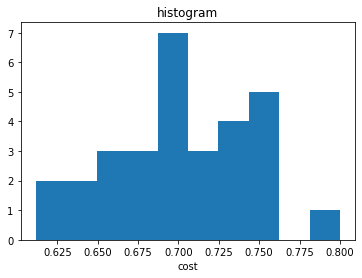

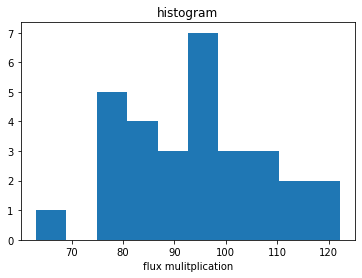

In [8]:
from helperTools import *
data=np.array([[  0.72915529,  85.3457536 ],
               [  0.71185617,  90.78150627],
               [  0.68487298,  99.26020394],
               [  0.66501233, 105.50084514],
               [  0.6815996 , 100.28876779],
               [  0.73050377,  84.92203024],
               [  0.6312657 , 116.1047594 ],
               [  0.69046492,  97.50309659],
               [  0.65054938, 110.04541246],
               [  0.68959857,  97.77532238],
               [  0.69965271,  94.61609614],
               [  0.75535224,  77.11410939],
               [  0.71007324,  91.34174027],
               [  0.80010193,  63.05279943],
               [  0.70272166,  93.65176404],
               [  0.73477944,  83.5785239 ],
               [  0.69400434,  96.39093282],
               [  0.68173254, 100.24699777],
               [  0.61169365, 122.25471658],
               [  0.75123372,  78.40823747],
               [  0.70718958,  92.24784801],
               [  0.7533029 ,  77.75805523],
               [  0.64452417, 111.93866476],
               [  0.70195747,  93.8918911 ],
               [  0.62724925, 117.36681228],
               [  0.70365725,  93.35778356],
               [  0.73178592,  84.51915345],
               [  0.75098683,  78.48581413],
               [  0.65079853, 109.96712499],
               [  0.7563169 ,  76.81099391]])
y1,y2=data.T
plt.hist(y1)
plt.title('histogram')
plt.xlabel("cost")
plt.show()
plt.title('histogram')
plt.hist(y2)
plt.xlabel('flux mulitplication')
plt.show()